In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [69]:
# // Load the datasets
cm = pd.read_csv('select-child-mortality-indicators_national_uga(1).csv', skiprows=[1])
imm = pd.read_csv('immunization_national_uga.csv', skiprows=[1])

In [70]:
# // Filter the data to include only total and preferred indicators
cm = cm[(cm['IsTotal'] == 1) & (cm['IsPreferred'] == 1)]
imm = imm[(imm['IsTotal'] == 1) & (imm['IsPreferred'] == 1)]

In [71]:
# define the indicators to analyze
mortality_indicators = [
    'Neonatal mortality rate',
    'Postneonatal mortality rate',
    'Infant mortality rate',
    'Child mortality rate',
    'Under-five mortality rate'
]

immunization_indicators = [
    'BCG vaccination received',
    'DPT 1 vaccination received',
    'DPT 2 vaccination received',
    'DPT 3 vaccination received',
    'Polio 1 vaccination received',
    'Polio 2 vaccination received',
    'Polio 3 vaccination received',
    'Measles vaccination received',
    'Fully vaccinated (8 basic antigens)',
    'Received no vaccinations'
]

In [72]:
# //processing of the mortality dataset
# Select important columns
cm_sel = cm[cm['Indicator'].isin(mortality_indicators)][
    ['SurveyYear', 'SurveyYearLabel', 'SurveyType', 'Indicator', 'Value', 'CILow', 'CIHigh', 'DenominatorWeighted']
]

# Pivot values to wide format
cm_wide = cm_sel.pivot_table(
    index=['SurveyYear', 'SurveyYearLabel', 'SurveyType'],
    columns='Indicator', values='Value', aggfunc='first'
).reset_index()
cm_wide.columns.name = None

# Pivot CILow
cm_ci_low = cm_sel.pivot_table(
    index=['SurveyYear', 'SurveyYearLabel', 'SurveyType'],
    columns='Indicator', values='CILow', aggfunc='first'
).reset_index()
cm_ci_low.columns.name = None
cm_ci_low.columns = [f'{c}_CILow' if c not in ['SurveyYear','SurveyYearLabel','SurveyType'] else c for c in cm_ci_low.columns]

# Pivot CIHigh
cm_ci_high = cm_sel.pivot_table(
    index=['SurveyYear', 'SurveyYearLabel', 'SurveyType'],
    columns='Indicator', values='CIHigh', aggfunc='first'
).reset_index()
cm_ci_high.columns.name = None
cm_ci_high.columns = [f'{c}_CIHigh' if c not in ['SurveyYear','SurveyYearLabel','SurveyType'] else c for c in cm_ci_high.columns]

# Sample size
cm_denom = cm_sel.drop_duplicates('SurveyYear')[['SurveyYear', 'DenominatorWeighted']].rename(
    columns={'DenominatorWeighted': 'Mortality_SampleSize_Weighted'})

# Merge all mortality parts together
cm_wide = cm_wide.merge(cm_ci_low, on=['SurveyYear','SurveyYearLabel','SurveyType'], how='left')
cm_wide = cm_wide.merge(cm_ci_high, on=['SurveyYear','SurveyYearLabel','SurveyType'], how='left')
cm_wide = cm_wide.merge(cm_denom, on='SurveyYear', how='left')

In [73]:
# //processing of the immunization dataset
# Select important columns
imm_sel = imm[imm['Indicator'].isin(immunization_indicators)][
    ['SurveyYear', 'Indicator', 'Value', 'DenominatorWeighted']
]

# Pivot to wide format
imm_wide = imm_sel.pivot_table(
    index=['SurveyYear'],
    columns='Indicator', values='Value', aggfunc='first'
).reset_index()
imm_wide.columns.name = None

# Sample size
imm_denom = imm_sel.drop_duplicates('SurveyYear')[['SurveyYear', 'DenominatorWeighted']].rename(
    columns={'DenominatorWeighted': 'Immunization_SampleSize_Weighted'})

imm_wide = imm_wide.merge(imm_denom, on='SurveyYear', how='left')

In [74]:
# //merge both datasets
# Merge on SurveyYear
merged = pd.merge(cm_wide, imm_wide, on='SurveyYear', how='outer')

# Add country identifiers
merged.insert(0, 'CountryName', 'Uganda')
merged.insert(0, 'ISO3', 'UGA')

# Sort by year and clean up
merged = merged.sort_values('SurveyYear').reset_index(drop=True)
merged.columns = [c.strip() for c in merged.columns]

# Save to CSV
merged.to_csv('uganda_child_health_merged.csv', index=False)
df = df.drop(columns=['Mortality_SampleSize_Weighted'])
print("✅ File saved successfully!")
print("Shape:", merged.shape)
print("cm_wide shape:", cm_wide.shape)
print("Columns:", cm_wide.columns.tolist())

✅ File saved successfully!
Shape: (7, 32)
cm_wide shape: (7, 19)
Columns: ['SurveyYear', 'SurveyYearLabel', 'SurveyType', 'Child mortality rate', 'Infant mortality rate', 'Neonatal mortality rate', 'Postneonatal mortality rate', 'Under-five mortality rate', 'Child mortality rate_CILow', 'Infant mortality rate_CILow', 'Neonatal mortality rate_CILow', 'Postneonatal mortality rate_CILow', 'Under-five mortality rate_CILow', 'Child mortality rate_CIHigh', 'Infant mortality rate_CIHigh', 'Neonatal mortality rate_CIHigh', 'Postneonatal mortality rate_CIHigh', 'Under-five mortality rate_CIHigh', 'Mortality_SampleSize_Weighted']


In [75]:
merged.shape          # how many rows and columns
merged.dtypes         # data types of each column
merged.info()         # overview of nulls and types
merged.describe()     # summary statistics (min, max, mean, std)
merged.isnull().sum() # count of missing values per column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ISO3                                 7 non-null      object 
 1   CountryName                          7 non-null      object 
 2   SurveyYear                           7 non-null      int64  
 3   SurveyYearLabel                      7 non-null      object 
 4   SurveyType                           7 non-null      object 
 5   Child mortality rate                 7 non-null      int64  
 6   Infant mortality rate                7 non-null      int64  
 7   Neonatal mortality rate              7 non-null      int64  
 8   Postneonatal mortality rate          7 non-null      int64  
 9   Under-five mortality rate            7 non-null      int64  
 10  Child mortality rate_CILow           7 non-null      int64  
 11  Infant mortality rate_CILow         

ISO3                                   0
CountryName                            0
SurveyYear                             0
SurveyYearLabel                        0
SurveyType                             0
Child mortality rate                   0
Infant mortality rate                  0
Neonatal mortality rate                0
Postneonatal mortality rate            0
Under-five mortality rate              0
Child mortality rate_CILow             0
Infant mortality rate_CILow            0
Neonatal mortality rate_CILow          0
Postneonatal mortality rate_CILow      0
Under-five mortality rate_CILow        0
Child mortality rate_CIHigh            0
Infant mortality rate_CIHigh           0
Neonatal mortality rate_CIHigh         0
Postneonatal mortality rate_CIHigh     0
Under-five mortality rate_CIHigh       0
Mortality_SampleSize_Weighted          7
BCG vaccination received               1
DPT 1 vaccination received             1
DPT 2 vaccination received             1
DPT 3 vaccinatio

In [79]:
# Clean uganda_child_health_merged.csv and save a cleaned version

try:
    df  
except NameError:
    df = pd.read_csv('uganda_child_health_merged.csv')

# 1) drop columns that are entirely empty
df_cols_clean = df.dropna(axis=1, how='all')

# 2) drop rows with any remaining missing values (strict clean)
cleaned_df = df_cols_clean.dropna().reset_index(drop=True)

# 3) if strict cleaning removes all rows, fallback to a threshold-based approach:
if cleaned_df.shape[0] == 0:
    # require rows to have at least 60% of columns non-null
    min_non_na = int(df_cols_clean.shape[1] * 0.6) or 1
    cleaned_df = df_cols_clean.dropna(thresh=min_non_na).reset_index(drop=True)

# Save cleaned dataset
cleaned_path = 'uganda_child_health_merged_cleaned.csv'
cleaned_df.to_csv(cleaned_path, index=False)

# Quick report
print("original shape:", df.shape)
print("after dropping all-empty columns:", df_cols_clean.shape)
print("cleaned shape:", cleaned_df.shape)
print(f"cleaned file saved to: {cleaned_path}")

original shape: (7, 33)
after dropping all-empty columns: (7, 32)
cleaned shape: (6, 32)
cleaned file saved to: uganda_child_health_merged_cleaned.csv


,Neonatal mortality rate,Infant mortality rate,Child mortality rate,Under-five mortality rate
count,7.000000,7.000000,7.000000,7.000000
mean,30.285714,70.000000,54.428571,120.428571
std,6.019809,20.165978,23.978165,41.218350
min,27.000000,43.000000,22.000000,64.000000
25%,27.000000,54.500000,35.000000,88.000000
50%,27.000000,71.000000,61.000000,128.000000
75%,30.500000,84.500000,70.500000,149.000000
max,43.000000,98.000000,87.000000,177.000000


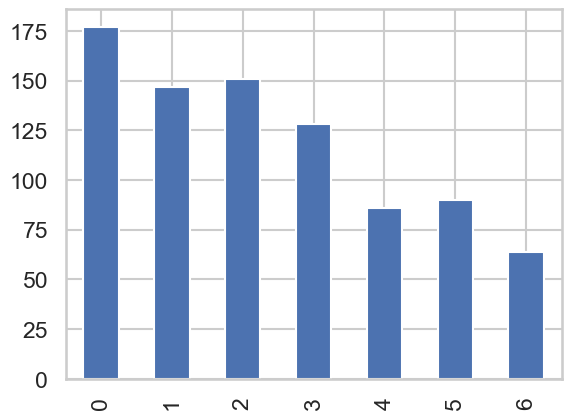

In [ ]:


# Distribution of under-five mortality rate across survey years
merged['Under-five mortality rate'].plot(kind='bar')

# Summary stats for all mortality indicators
merged[['Neonatal mortality rate', 'Infant mortality rate',
        'Child mortality rate', 'Under-five mortality rate']].describe()

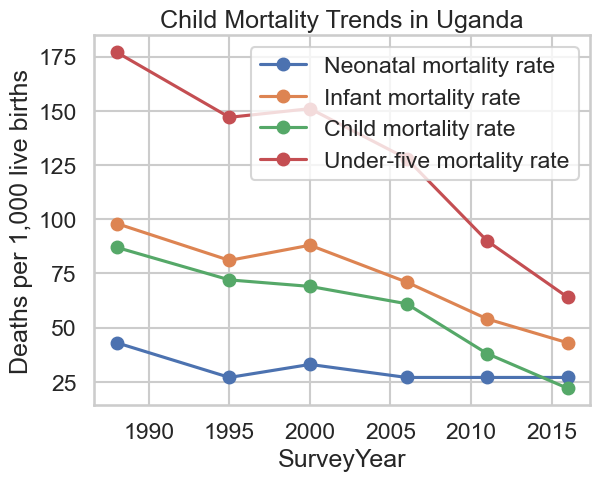

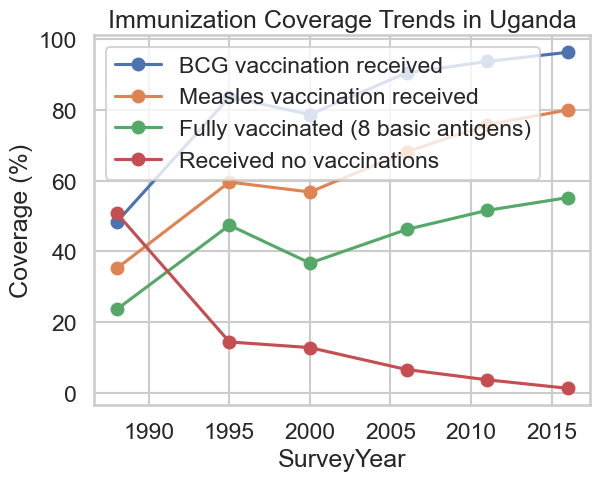

In [80]:


# Mortality trends over time
# ensure merged_cleaned is available (load from cleaned CSV if needed), coerce year and use it as merged for the rest of the cell
try:
   merged_cleaned
except NameError:
   try:
      merged_cleaned = pd.read_csv('uganda_child_health_merged_cleaned.csv')
   except Exception:
      # fallback to existing merged if cleaned file is not present
      merged_cleaned = merged.copy()

merged_cleaned['SurveyYear'] = merged_cleaned['SurveyYear'].astype(int)
merged_cleaned = merged_cleaned.sort_values('SurveyYear').reset_index(drop=True)

# point merged to the cleaned dataframe so subsequent plotting in this cell uses the cleaned data
merged = merged_cleaned

merged.plot(x='SurveyYear',
         y=['Neonatal mortality rate', 'Infant mortality rate',
            'Child mortality rate', 'Under-five mortality rate'],
         marker='o', title='Child Mortality Trends in Uganda')
plt.ylabel('Deaths per 1,000 live births')
plt.show()

# Vaccination coverage trends over time
merged_cleaned.plot(x='SurveyYear',
            y=['BCG vaccination received', 'Measles vaccination received',
               'Fully vaccinated (8 basic antigens)', 'Received no vaccinations'],
            marker='o', title='Immunization Coverage Trends in Uganda')
plt.ylabel('Coverage (%)')
plt.show()

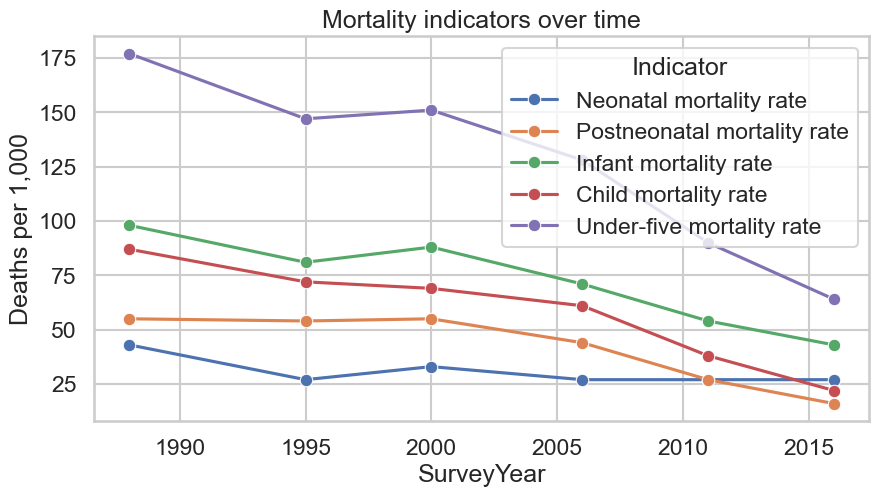

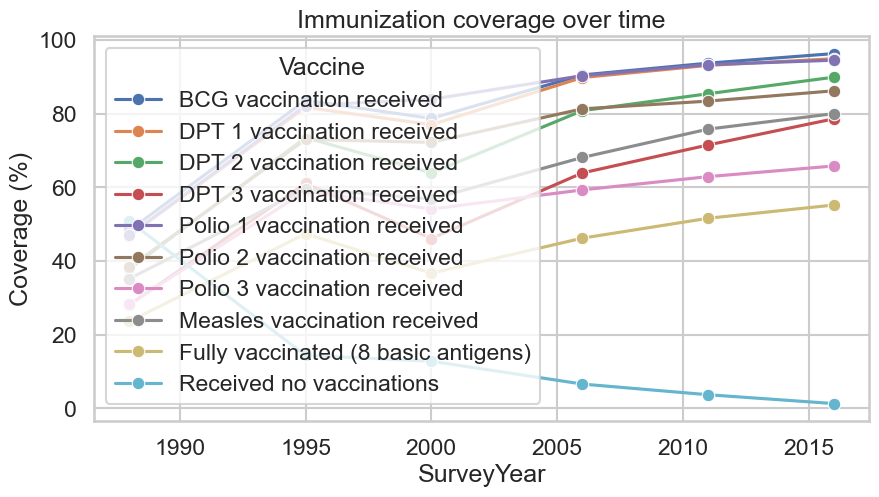

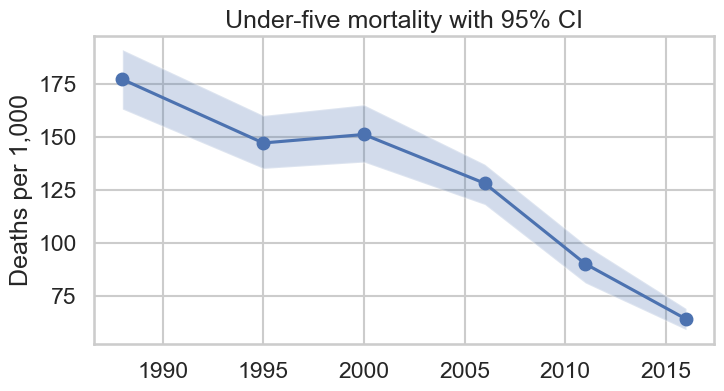

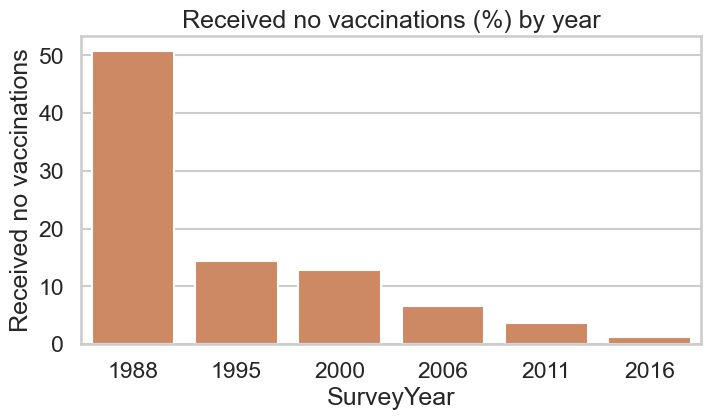

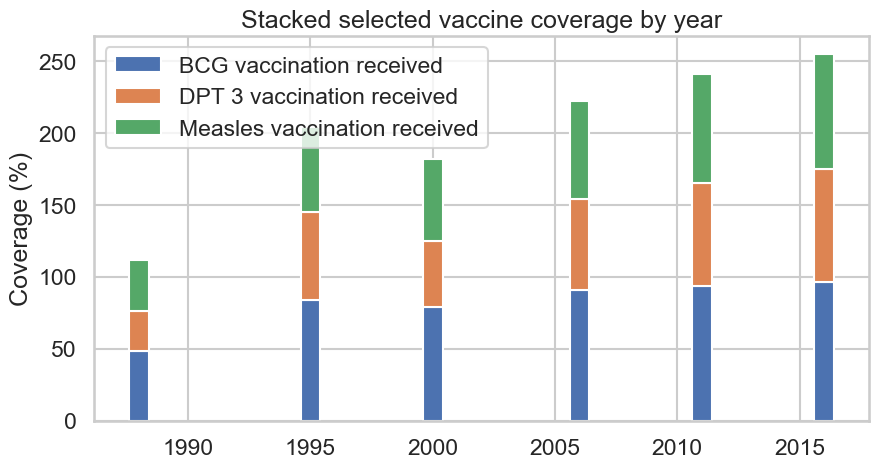

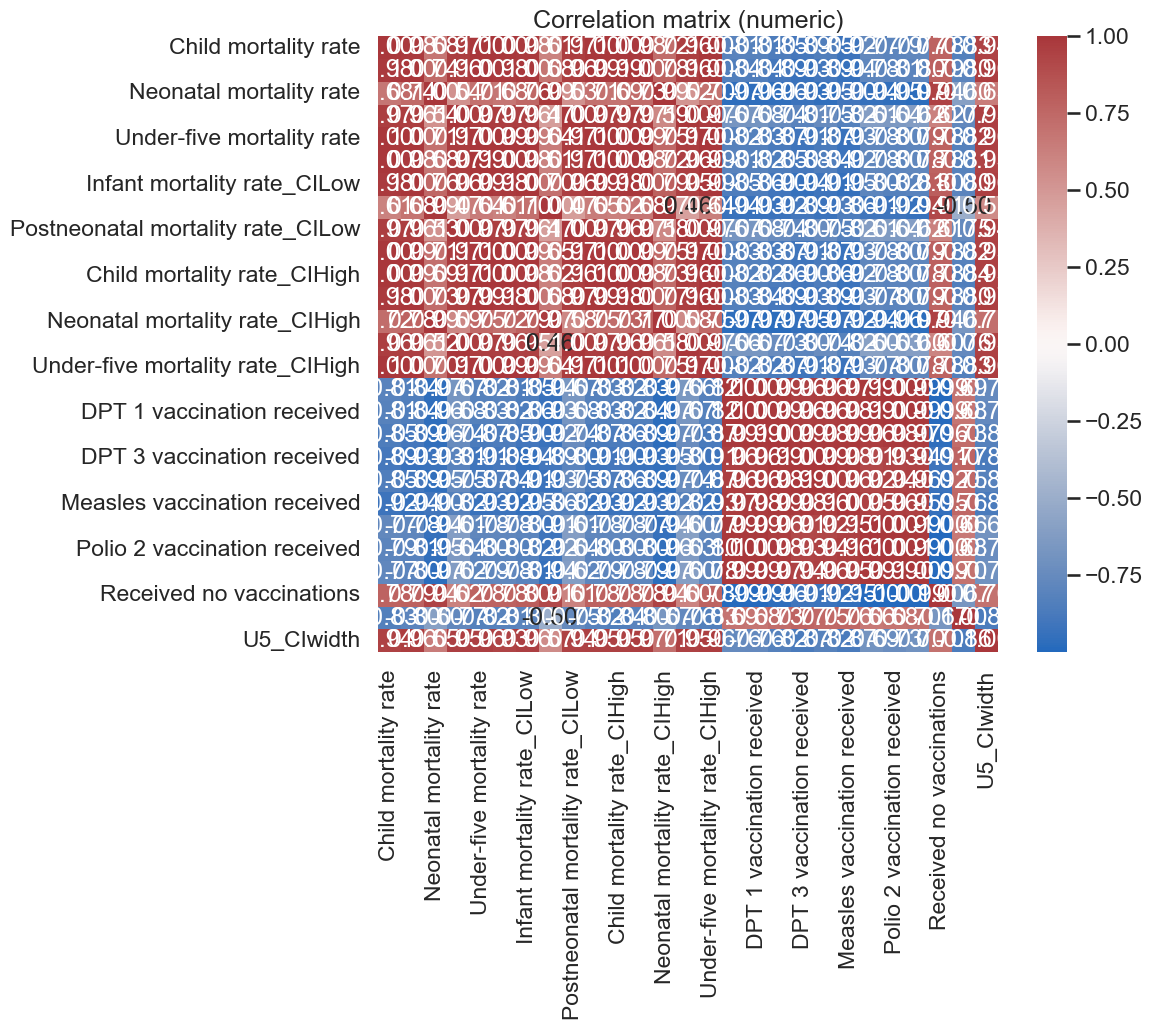

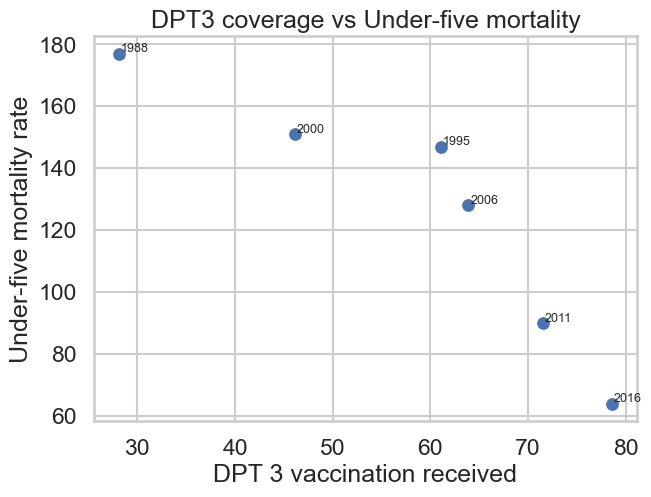

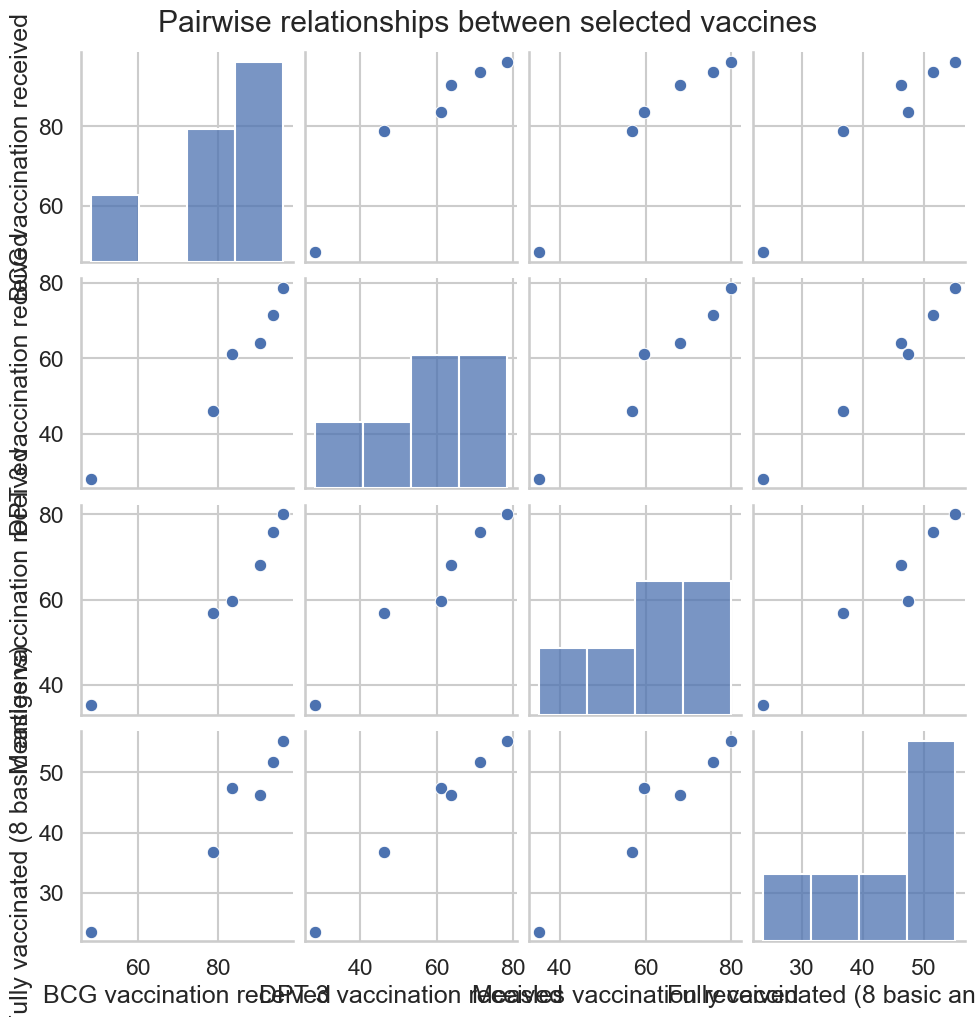

C:\Users\USER\AppData\Local\Temp\ipykernel_1868\245547587.py:82: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = row[rad_cols].fillna(0).values


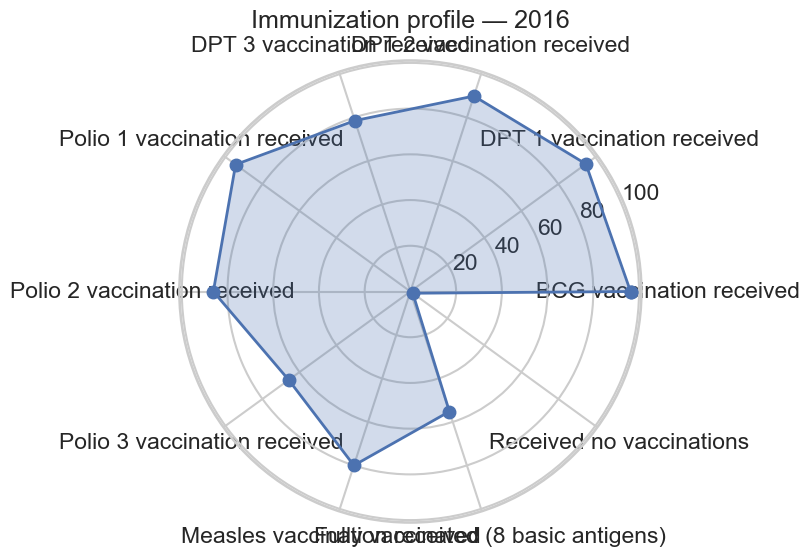

<Figure size 1000x600 with 0 Axes>

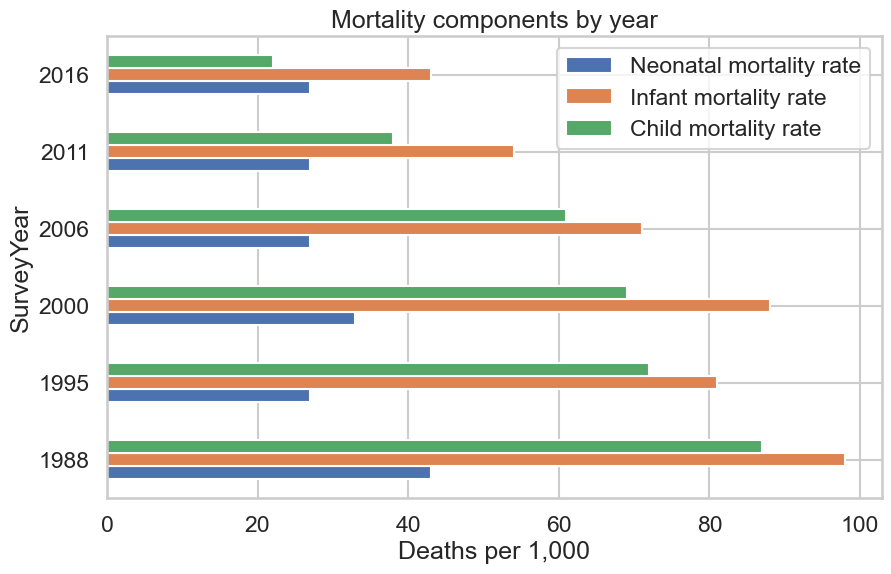

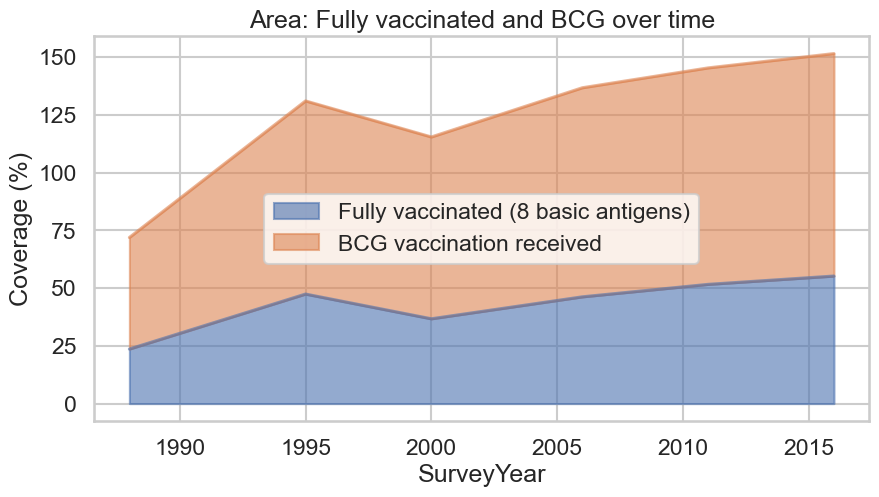

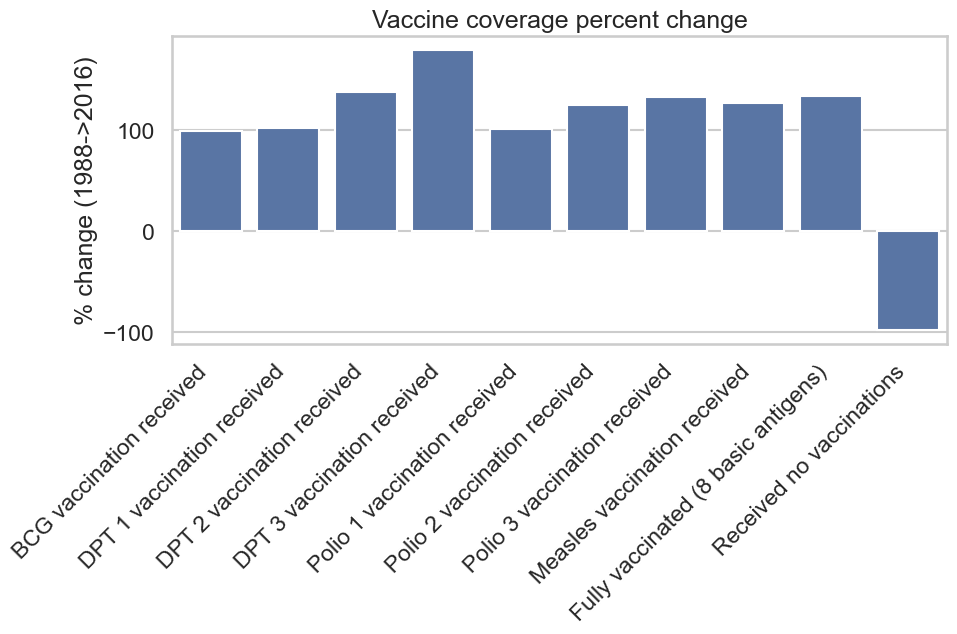

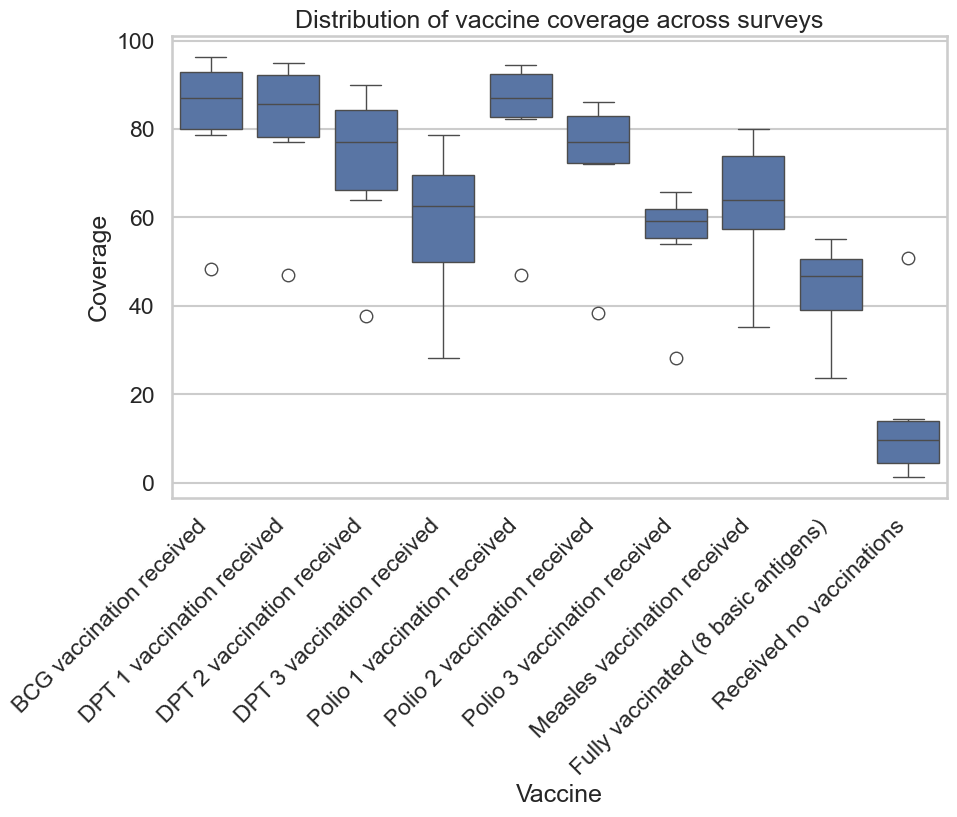

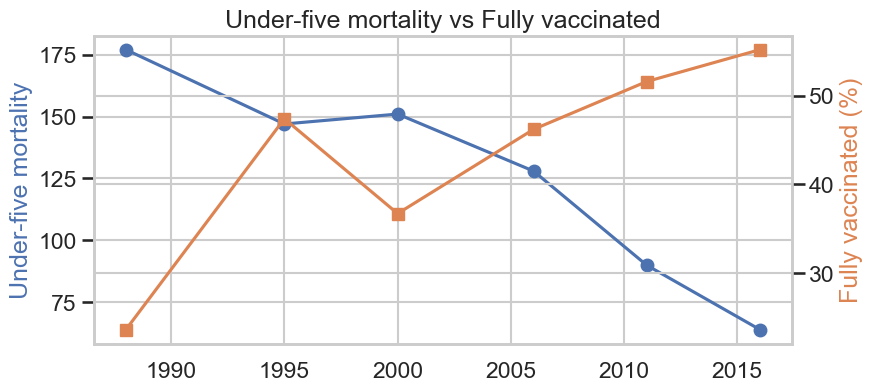

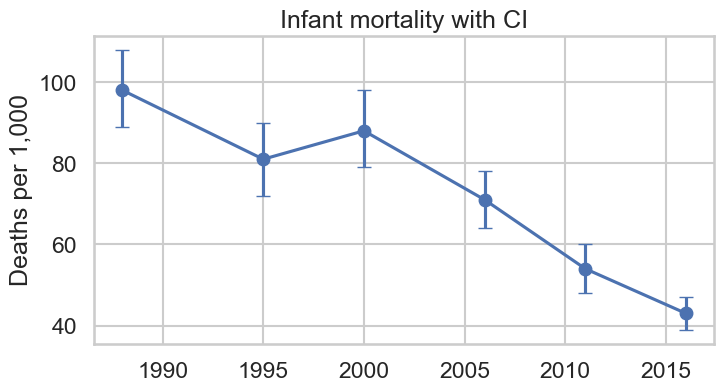

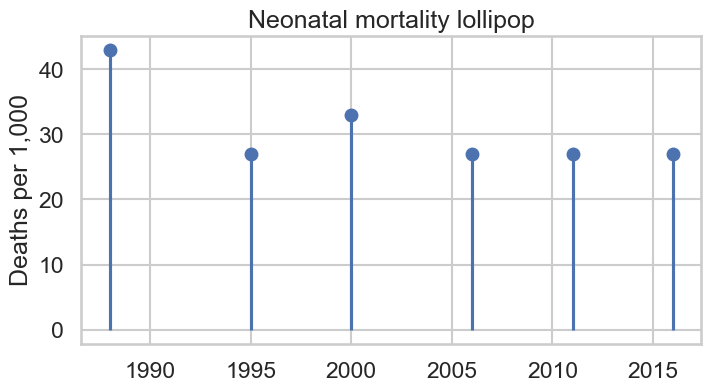

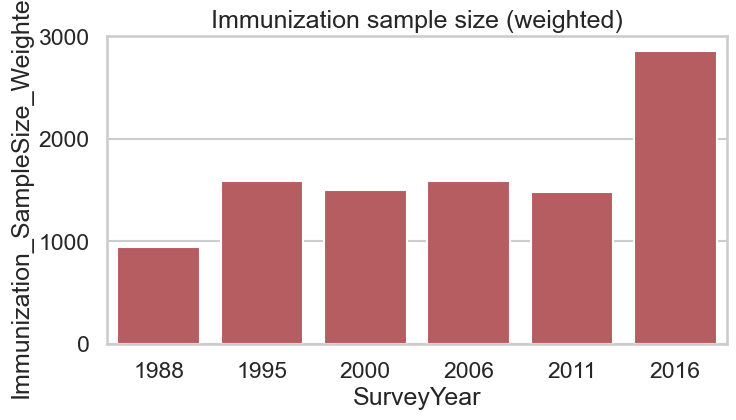

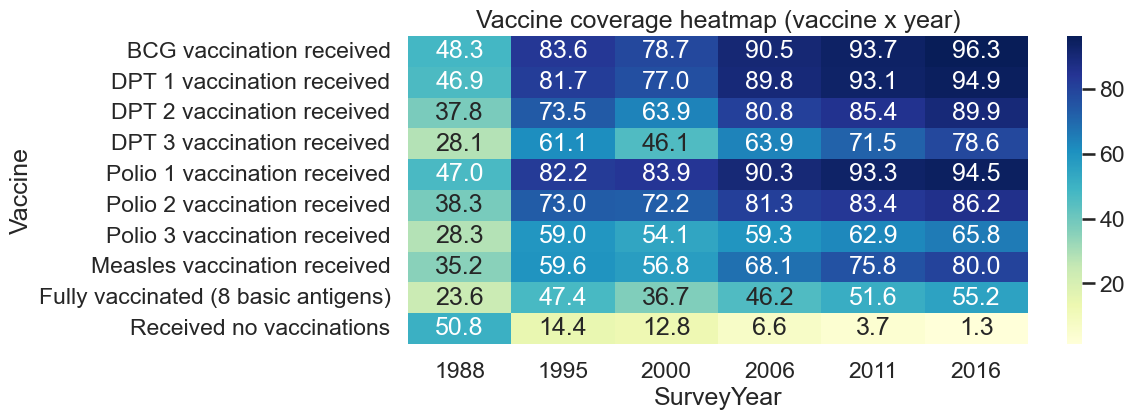

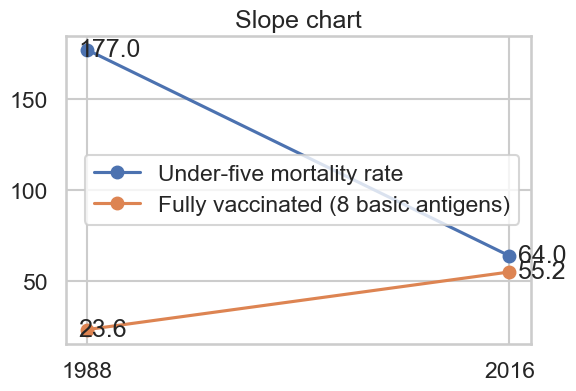

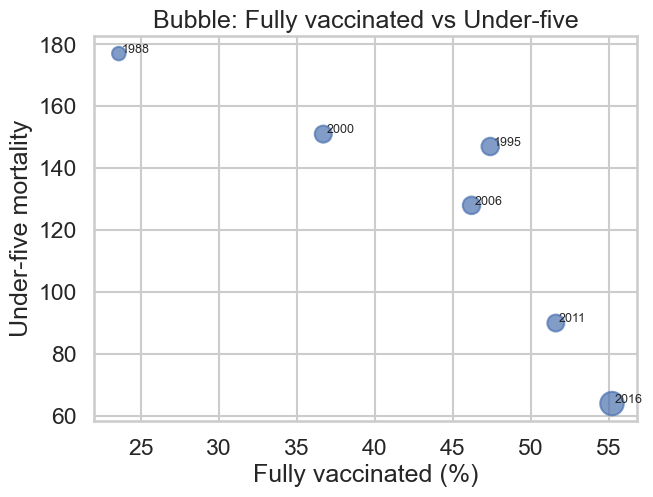

C:\Users\USER\AppData\Local\Temp\ipykernel_1868\245547587.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(declines.keys()), y=list(declines.values()), palette='mako')


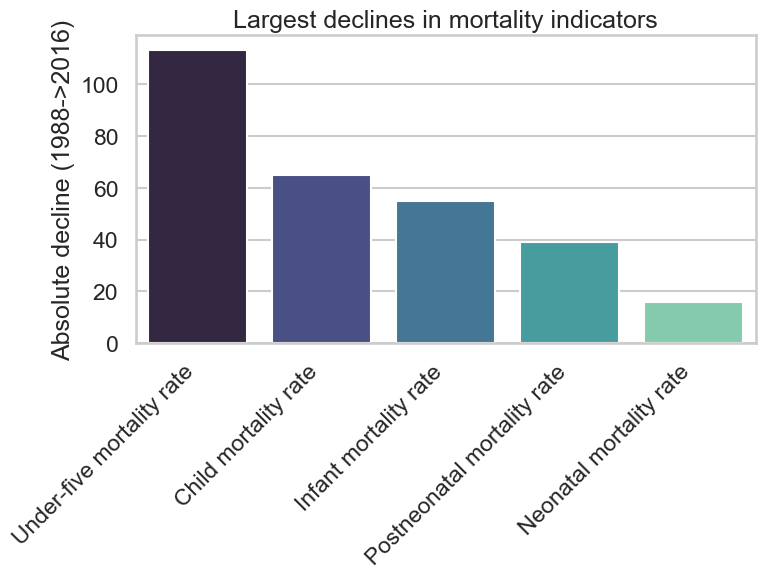

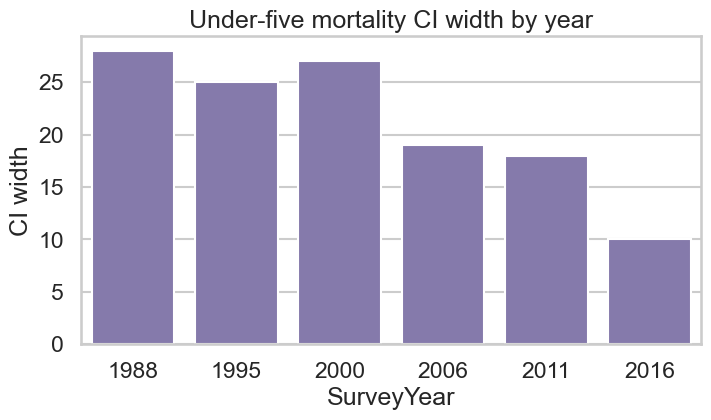

In [81]:


sns.set(style="whitegrid", context="talk")

df = pd.read_csv('uganda_child_health_merged_cleaned.csv')
df['SurveyYear'] = df['SurveyYear'].astype(int)
df = df.sort_values('SurveyYear').reset_index(drop=True)

# derive lists (use existing names if present)
try:
    mort_cols = mortality_indicators
except NameError:
    mort_cols = [c for c in df.columns if 'mortality rate' in c.lower()]

try:
    imm_cols = immunization_indicators
except NameError:
    imm_cols = [c for c in df.columns if 'vaccination' in c.lower() or 'fully vaccinated' in c.lower() or 'received no vaccinations' in c.lower()]

# Helper long formats
imm_long = df.melt(id_vars=['SurveyYear'], value_vars=[c for c in imm_cols if c in df.columns],
                   var_name='Vaccine', value_name='Coverage')
mort_long = df.melt(id_vars=['SurveyYear'], value_vars=[c for c in mort_cols if c in df.columns],
                    var_name='Indicator', value_name='Deaths')

# 1) Line plot: all mortality indicators with markers
plt.figure(figsize=(10,5))
sns.lineplot(data=mort_long, x='SurveyYear', y='Deaths', hue='Indicator', marker='o')
plt.title('Mortality indicators over time'); plt.ylabel('Deaths per 1,000'); plt.show()

# 2) Line plot: all immunization coverages
plt.figure(figsize=(10,5))
sns.lineplot(data=imm_long, x='SurveyYear', y='Coverage', hue='Vaccine', marker='o')
plt.title('Immunization coverage over time'); plt.ylabel('Coverage (%)'); plt.show()

# 3) Under-five mortality with CI band
if 'Under-five mortality rate_CILow' in df.columns and 'Under-five mortality rate_CIHigh' in df.columns:
    plt.figure(figsize=(8,4))
    plt.plot(df['SurveyYear'], df['Under-five mortality rate'], marker='o')
    plt.fill_between(df['SurveyYear'], df['Under-five mortality rate_CILow'], df['Under-five mortality rate_CIHigh'], alpha=0.25)
    plt.title('Under-five mortality with 95% CI'); plt.ylabel('Deaths per 1,000'); plt.show()

# 4) Bar: Received no vaccinations by year
if 'Received no vaccinations' in df.columns:
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x='SurveyYear', y='Received no vaccinations', color='C1')
    plt.title('Received no vaccinations (%) by year'); plt.show()

# 5) Stacked bar (selected vaccines) per year
stack_cols = [c for c in ['BCG vaccination received','DPT 3 vaccination received','Measles vaccination received'] if c in df.columns]
if stack_cols:
    plt.figure(figsize=(10,5))
    bottom = np.zeros(len(df))
    for col in stack_cols:
        plt.bar(df['SurveyYear'], df[col].fillna(0), bottom=bottom, label=col)
        bottom += df[col].fillna(0).values
    plt.legend(); plt.title('Stacked selected vaccine coverage by year'); plt.ylabel('Coverage (%)'); plt.show()

# 6) Heatmap: correlation of numeric columns
plt.figure(figsize=(10,8))
num = df.select_dtypes(include='number').drop(columns=['SurveyYear'], errors='ignore')
sns.heatmap(num.corr(), annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation matrix (numeric)'); plt.show()

# 7) Scatter: DPT3 vs Under-five mortality
if 'DPT 3 vaccination received' in df.columns and 'Under-five mortality rate' in df.columns:
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df, x='DPT 3 vaccination received', y='Under-five mortality rate', s=100)
    for i,row in df.iterrows():
        plt.text(row['DPT 3 vaccination received']+0.2, row['Under-five mortality rate']+0.5, int(row['SurveyYear']), fontsize=9)
    plt.title('DPT3 coverage vs Under-five mortality'); plt.show()

# 8) Pairplot for selected immunization indicators
sel = [c for c in ['BCG vaccination received','DPT 3 vaccination received','Measles vaccination received','Fully vaccinated (8 basic antigens)'] if c in df.columns]
if len(sel) >= 2:
    sns.pairplot(df[sel])
    plt.suptitle('Pairwise relationships between selected vaccines', y=1.02); plt.show()

# 9) Radar chart of immunization coverage (latest year)
latest = df['SurveyYear'].max()
row = df[df['SurveyYear']==latest].iloc[0]
rad_cols = [c for c in imm_cols if c in df.columns]
if rad_cols:
    values = row[rad_cols].fillna(0).values
    angles = np.linspace(0, 2*np.pi, len(rad_cols), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]
    fig = plt.figure(figsize=(6,6)); ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'o-', linewidth=2); ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), rad_cols)
    ax.set_title(f'Immunization profile — {latest}'); plt.show()

# 10) Horizontal bar: neonatal, infant, child mortality by year (grouped)
plt.figure(figsize=(10,6))
mort_subset = ['Neonatal mortality rate','Infant mortality rate','Child mortality rate']
mort_subset = [c for c in mort_subset if c in df.columns]
if mort_subset:
    df.set_index('SurveyYear')[mort_subset].plot(kind='barh', figsize=(10,6))
    plt.title('Mortality components by year'); plt.xlabel('Deaths per 1,000'); plt.show()

# 11) Area plot: fully vaccinated + BCG over time
a_cols = [c for c in ['Fully vaccinated (8 basic antigens)','BCG vaccination received'] if c in df.columns]
if a_cols:
    df.set_index('SurveyYear')[a_cols].plot(kind='area', figsize=(10,5), alpha=0.6)
    plt.title('Area: Fully vaccinated and BCG over time'); plt.ylabel('Coverage (%)'); plt.show()

# 12) Percent change 1988->2016 for vaccines
if 1988 in df['SurveyYear'].values and 2016 in df['SurveyYear'].values:
    df88 = df[df['SurveyYear']==1988].iloc[0]
    df16 = df[df['SurveyYear']==2016].iloc[0]
    pct = {}
    for c in imm_cols:
        if c in df.columns:
            v0 = df88.get(c, np.nan); v1 = df16.get(c, np.nan)
            if pd.notnull(v0) and v0!=0:
                pct[c] = (v1 - v0)/v0*100
    if pct:
        plt.figure(figsize=(10,4)); sns.barplot(x=list(pct.keys()), y=list(pct.values()))
        plt.xticks(rotation=45, ha='right'); plt.ylabel('% change (1988->2016)'); plt.title('Vaccine coverage percent change'); plt.show()

# 13) Boxplot of vaccine coverages (across years)
plt.figure(figsize=(10,6))
sns.boxplot(data=imm_long, x='Vaccine', y='Coverage')
plt.xticks(rotation=45, ha='right'); plt.title('Distribution of vaccine coverage across surveys'); plt.show()

# 14) Dual-axis: Under-five mortality and Fully vaccinated
if 'Fully vaccinated (8 basic antigens)' in df.columns:
    fig, ax1 = plt.subplots(figsize=(9,4))
    ax1.plot(df['SurveyYear'], df['Under-five mortality rate'], 'C0-o'); ax1.set_ylabel('Under-five mortality', color='C0')
    ax2 = ax1.twinx(); ax2.plot(df['SurveyYear'], df['Fully vaccinated (8 basic antigens)'], 'C1-s'); ax2.set_ylabel('Fully vaccinated (%)', color='C1')
    plt.title('Under-five mortality vs Fully vaccinated'); plt.show()

# 15) Errorbar plot of Infant mortality with CI
if 'Infant mortality rate_CILow' in df.columns and 'Infant mortality rate_CIHigh' in df.columns:
    y = df['Infant mortality rate']
    yerr = [y - df['Infant mortality rate_CILow'], df['Infant mortality rate_CIHigh'] - y]
    plt.figure(figsize=(8,4))
    plt.errorbar(df['SurveyYear'], y, yerr=yerr, fmt='o-', capsize=5)
    plt.title('Infant mortality with CI'); plt.ylabel('Deaths per 1,000'); plt.show()

# 16) Lollipop chart for Neonatal mortality
if 'Neonatal mortality rate' in df.columns:
    plt.figure(figsize=(8,4))
    plt.stem(df['SurveyYear'], df['Neonatal mortality rate'], basefmt=" ")
    plt.title('Neonatal mortality lollipop'); plt.ylabel('Deaths per 1,000'); plt.show()

# 17) Bar chart of immunization sample sizes
if 'Immunization_SampleSize_Weighted' in df.columns:
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x='SurveyYear', y='Immunization_SampleSize_Weighted', color='C3')
    plt.title('Immunization sample size (weighted)'); plt.show()

# 18) Heatmap: vaccine x year
vax_pivot = df.set_index('SurveyYear')[[c for c in imm_cols if c in df.columns]]
if not vax_pivot.empty:
    plt.figure(figsize=(10,4))
    sns.heatmap(vax_pivot.T, annot=True, fmt=".1f", cmap='YlGnBu')
    plt.title('Vaccine coverage heatmap (vaccine x year)'); plt.ylabel('Vaccine'); plt.show()

# 19) Slope chart between first and last survey for Under-five and Fully vaccinated
first_year, last_year = df['SurveyYear'].min(), df['SurveyYear'].max()
pairs = []
for metric in ['Under-five mortality rate', 'Fully vaccinated (8 basic antigens)']:
    if metric in df.columns:
        v0 = df.loc[df['SurveyYear']==first_year, metric].values
        v1 = df.loc[df['SurveyYear']==last_year, metric].values
        if v0.size and v1.size:
            pairs.append((metric, float(v0[0]), float(v1[0])))
if pairs:
    plt.figure(figsize=(6,4))
    for i, (name, v0, v1) in enumerate(pairs):
        plt.plot([0,1],[v0,v1], marker='o', label=name)
        plt.text(-0.02, v0, f'{v0}', va='center')
        plt.text(1.02, v1, f'{v1}', va='center')
    plt.xticks([0,1],[first_year,last_year]); plt.legend(); plt.title('Slope chart'); plt.show()

# 20) Bubble chart: Fully vaccinated vs Under-five mortality sized by sample
if 'Fully vaccinated (8 basic antigens)' in df.columns and 'Under-five mortality rate' in df.columns:
    sizes = df.get('Immunization_SampleSize_Weighted', pd.Series(1000, index=df.index)).fillna(100)
    plt.figure(figsize=(7,5))
    plt.scatter(df['Fully vaccinated (8 basic antigens)'], df['Under-five mortality rate'], s=sizes/10, alpha=0.7)
    for i,row in df.iterrows():
        plt.text(row['Fully vaccinated (8 basic antigens)']+0.2, row['Under-five mortality rate']+0.3, int(row['SurveyYear']), fontsize=9)
    plt.xlabel('Fully vaccinated (%)'); plt.ylabel('Under-five mortality'); plt.title('Bubble: Fully vaccinated vs Under-five'); plt.show()

# 21) Pareto-style: absolute decline in mortality indicators (1988->2016)
declines = {}
if first_year in df['SurveyYear'].values and last_year in df['SurveyYear'].values:
    r0 = df[df['SurveyYear']==first_year].iloc[0]
    r1 = df[df['SurveyYear']==last_year].iloc[0]
    for c in mort_cols:
        if c in df.columns:
            declines[c] = r0[c] - r1[c]
    declines = dict(sorted(declines.items(), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(declines.keys()), y=list(declines.values()), palette='mako')
    plt.xticks(rotation=45, ha='right'); plt.ylabel('Absolute decline (1988->2016)'); plt.title('Largest declines in mortality indicators'); plt.show()

# 22) CI width over time for Under-five mortality
if 'Under-five mortality rate_CILow' in df.columns and 'Under-five mortality rate_CIHigh' in df.columns:
    df['U5_CIwidth'] = df['Under-five mortality rate_CIHigh'] - df['Under-five mortality rate_CILow']
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x='SurveyYear', y='U5_CIwidth', color='C4')
    plt.title('Under-five mortality CI width by year'); plt.ylabel('CI width'); plt.show()